In [492]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [493]:
# Load the CSV file into a DataFrame
file_path_1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_2010_2014.csv' # Daily technical data (CRSP)
file_path_2 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_q_data_2010_2014.csv' # Fundamental data (Compustat)
file_path_3 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_quarterly_ratiodata_2010_2014.csv' # Fundamental ratios (Compustat)

df1 = pd.read_csv(file_path_1)
df2 = pd.read_csv(file_path_2)
df3 = pd.read_csv(file_path_3)

#Convert date columns to datetime format
df1['date'] = pd.to_datetime(df1['date'])  # CRSP daily data
df2['datadate'] = pd.to_datetime(df2['datadate'])  # Fundamental data
df3['qdate'] = pd.to_datetime(df3['qdate'])  # Financial ratios data

print(df2.head())

   gvkey   datadate  fyearq  fqtr indfmt consol popsrc datafmt  tic curcdq  \
0   4503 2009-12-31    2009     4   INDL      C      D     STD  XOM    USD   
1   4503 2010-03-31    2010     1   INDL      C      D     STD  XOM    USD   
2   4503 2010-06-30    2010     2   INDL      C      D     STD  XOM    USD   
3   4503 2010-09-30    2010     3   INDL      C      D     STD  XOM    USD   
4   4503 2010-12-31    2010     4   INDL      C      D     STD  XOM    USD   

  datacqtr datafqtr  epsfxq       ltq     niq    revtq    capxy costat  
0   2009Q4   2009Q4    1.27  117931.0  6050.0  80106.0  22491.0      A  
1   2010Q1   2010Q1    1.33  125082.0  6300.0  80222.0   5756.0      A  
2   2010Q2   2010Q2    1.60  145701.0  7560.0  82747.0  11400.0      A  
3   2010Q3   2010Q3    1.44  149394.0  7350.0  85181.0  19201.0      A  
4   2010Q4   2010Q4    1.85  149831.0  9250.0  93428.0  26871.0      A  


In [494]:
# QUARTERLY PERCENTAGE CHANGES

# Make a copy of df2 to avoid modifying the original data
df2_pct = df2.copy()

# Identify numeric columns that should be converted to percentage changes
# Exclude non-numeric columns such as 'gvkey', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc', 'datafmt', 'tic', 'curcdq', 'datacqtr', 'datafqtr', 'costat'
columns_to_change = ['epsfxq', 'ltq', 'niq', 'revtq', 'capxy']

# Apply pct_change to each selected column and multiply by 100 to express as percentage
df2_pct[columns_to_change] = df2[columns_to_change].pct_change() * 100

# Sort by qdate and public_date to ensure the most recent public_date comes last
df3_sorted = df3.sort_values(by=['qdate', 'public_date'])

# Drop duplicates to keep only the latest public_date for each qdate
df3_latest = df3_sorted.drop_duplicates(subset='qdate', keep='last')

# Make a copy to avoid modifying the original df3_latest
df3_latest_pct = df3_latest.copy()

# Select columns to calculate percentage change, excluding identifier and date columns
columns_to_change = ['npm', 'de_ratio', 'curr_ratio', 'ptb']

# Apply pct_change to each selected column and multiply by 100 to express as percentage
df3_latest_pct[columns_to_change] = df3_latest[columns_to_change].pct_change() * 100

print(df3_latest_pct.head())

    permno       adate      qdate public_date        npm  de_ratio  \
0    11850  2008-12-31 2009-09-30  2010-01-31        NaN       NaN   
3    11850  2009-12-31 2009-12-31  2010-04-30 -10.256410  2.301055   
6    11850  2009-12-31 2010-03-31  2010-07-31   0.000000  1.593252   
9    11850  2009-12-31 2010-06-30  2010-10-31  11.428571 -0.830258   
12   11850  2009-12-31 2010-09-30  2011-01-31   6.410256 -1.488372   

    curr_ratio        ptb TICKER  
0          NaN        NaN    XOM  
3   -15.120000   1.926370    XOM  
6     2.827521  -6.299874    XOM  
9    -1.741522 -13.850291    XOM  
12   -1.679104  17.377732    XOM  


In [495]:
# First merge daily technical data (df1) with fundamental data (df2)
# Merge on the nearest quarter date for Exxon
df_combined_1_2 = pd.merge_asof(
    df1,  # Daily data sorted by date
    df2_pct,  # Fundamental data sorted by quarterly date
    left_on='date', right_on='datadate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Now merge with the cleaned financial ratios (df3_latest)
df_combined_all = pd.merge_asof(
    df_combined_1_2.sort_values('date'),  # Combined data sorted by date
    df3_latest_pct.sort_values('qdate'),  # Financial ratios sorted by quarterly date
    left_on='date', right_on='qdate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Display the first few rows of the final combined dataset
print(df_combined_all.head())

   PERMNO       date TICKER_x   BIDLO  ASKHI    PRC       VOL       RET  \
0   11850 2010-01-04      XOM  68.190  69.26  69.15  27811300  0.014078   
1   11850 2010-01-05      XOM  68.800  69.45  69.42  30178600  0.003905   
2   11850 2010-01-06      XOM  69.340  70.60  70.02  35047500  0.008643   
3   11850 2010-01-07      XOM  69.415  70.06  69.80  27194100 -0.003142   
4   11850 2010-01-08      XOM  69.220  69.75  69.52  24899500 -0.004012   

   OPENPRC  gvkey  ... costat  permno       adate      qdate public_date  \
0    68.72   4503  ...      A   11850  2009-12-31 2009-12-31  2010-04-30   
1    69.19   4503  ...      A   11850  2009-12-31 2009-12-31  2010-04-30   
2    69.45   4503  ...      A   11850  2009-12-31 2009-12-31  2010-04-30   
3    69.90   4503  ...      A   11850  2009-12-31 2009-12-31  2010-04-30   
4    69.69   4503  ...      A   11850  2009-12-31 2009-12-31  2010-04-30   

        npm  de_ratio curr_ratio      ptb TICKER_y  
0 -10.25641  2.301055     -15.12  1.926

In [496]:
# Filter the DataFrame to remove unnecessary/repeated collumns
columns_to_keep = [
    'date', 
    'PRC', 'VOL', 'RET', 
    'epsfxq', 'ltq', 'niq', 'revtq', 
    'capxy', 'npm', 'de_ratio', 'curr_ratio', 'ptb'
]
df_filtered = df_combined_all[columns_to_keep]

# Define new names for columns to make them more understandable
column_renames = {
    'date': 'Date', 
    'PRC': 'Price', 
    'VOL': 'Volume', 
    'RET': 'Return',
    'epsfxq': 'Earnings_Per_Share', 
    'ltq': 'Long_Term_Debt', 
    'niq': 'Net_Income', 
    'revtq': 'Revenue', 
    'capxy': 'Capital_Expenditure', 
    'npm': 'Net_Profit_Margin', 
    'de_ratio': 'Debt_Equity_Ratio', 
    'curr_ratio': 'Current_Ratio', 
    'ptb': 'Price_To_Book_Ratio'
}

# Apply the filter and rename the columns
df_filtered = df_combined_all[columns_to_keep].rename(columns=column_renames)

# Calculate the percentage change in price over a month (next 30 days)
df_filtered['Monthly_Percent_Change'] = (
    (df_filtered['Price'].shift(-30) - df_filtered['Price']) / df_filtered['Price'] * 100
)

# Move the 'Price' column to the end of the DataFrame
price_col = df_filtered.pop('Price')
df_filtered['Price'] = price_col

# Display the first few rows of the renamed DataFrame
print(df_filtered.head())


        Date    Volume    Return  Earnings_Per_Share  Long_Term_Debt  \
0 2010-01-04  27811300  0.014078                 NaN             NaN   
1 2010-01-05  30178600  0.003905                 NaN             NaN   
2 2010-01-06  35047500  0.008643                 NaN             NaN   
3 2010-01-07  27194100 -0.003142                 NaN             NaN   
4 2010-01-08  24899500 -0.004012                 NaN             NaN   

   Net_Income  Revenue  Capital_Expenditure  Net_Profit_Margin  \
0         NaN      NaN                  NaN          -10.25641   
1         NaN      NaN                  NaN          -10.25641   
2         NaN      NaN                  NaN          -10.25641   
3         NaN      NaN                  NaN          -10.25641   
4         NaN      NaN                  NaN          -10.25641   

   Debt_Equity_Ratio  Current_Ratio  Price_To_Book_Ratio  \
0           2.301055         -15.12              1.92637   
1           2.301055         -15.12              1

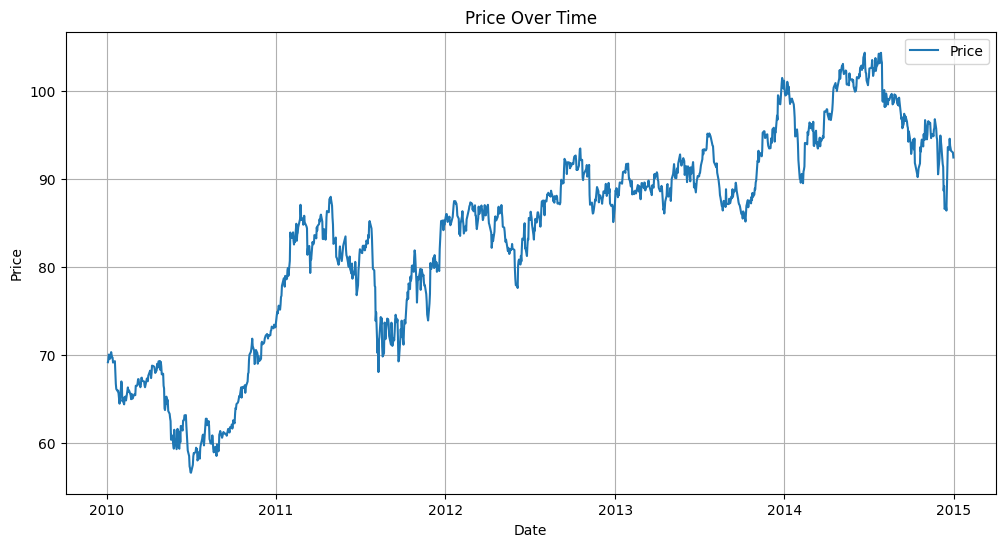

In [497]:
import matplotlib.pyplot as plt

# Plot Price over time
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Date'], df_filtered['Price'], label='Price', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [498]:
# Calculate percentage change for 'Price' and replace it
df_filtered['Price'] = df_filtered['Price'].pct_change() * 100

# Calculate percentage changes for the previous 30 days
for i in range(0, 31):
    df_filtered[f'Price_Day_{i}'] = df_filtered['Price'].shift(i)

price_col = df_filtered.pop('Price')

df_filtered.dropna(inplace=True)




In [499]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/filtered_exxon_data.csv'  # Replace with your actual file path
df_filtered.to_csv(file_path, index=False)
